# **A deep learning approach for Deep Fake Video Detection**

# XceptionNet + BiLSTM

In [ ]:
# Mount the gogle drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.2 MB/s eta 0:00:00


In [ ]:
pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 60.0 MB/s eta 0:00:00


In [ ]:
# import the required libraries
import os
import cv2
import csv
import shutil
import numpy as np
import glob
import json
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from facenet_pytorch import MTCNN
from google.colab.patches import cv2_imshow
from tensorflow import keras
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from PIL import Image 
from numpy import savez_compressed
from numpy import asarray
from os import listdir
from mtcnn.mtcnn import MTCNN

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


In [ ]:
# set the hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

MAX_SEQ_LENGTH = 50
NUM_FEATURES = 2048

## Video Classification with BiLSTM

In [ ]:
# from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from PIL import Image 
from numpy import savez_compressed
from numpy import asarray
from os import listdir
from mtcnn.mtcnn import MTCNN

In [ ]:
train_df = pd.read_csv('/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/trainLabels (1).csv', dtype=str)
train_df.head()

In [ ]:
test_df = pd.read_csv('/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/testLabels (1).csv', dtype=str)
test_df.head()

In [ ]:
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

In [ ]:
import cv2

def play_video(path):
  cap = cv2.VideoCapture(path)
  count = 0 

  while cap.isOpened() and count<20: # to print 20 frames in the video 
      ret, frame = cap.read()

      if not ret:
          break

      cv2_imshow(frame)
      count = count + 1
      # Exit if 'q' is pressed
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break

  cap.release()
  cv2.destroyAllWindows()

In [ ]:
play_video("/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/fufcmupzen.mp4")

In [ ]:
#Method to extract Face
def extract_image(image):
  # img1 = Image.open(image)            #open the image
  # img1 = img1.convert('RGB')          #convert the image to RGB format 
  # pixels = asarray(img1)              #convert the image to numpy array
  detector = MTCNN()                  #assign the MTCNN detector
  f = detector.detect_faces(image)
  #fetching the (x,y)co-ordinate and (width-->w, height-->h) of the image
  x1,y1,w,h = f[0]['box']             
  x1, y1 = abs(x1), abs(y1)
  x2 = abs(x1+w)
  y2 = abs(y1+h)
  #locate the co-ordinates of face in the image
  store_face = image[y1:y2,x1:x2]
  plt.imshow(store_face)
  image1 = Image.fromarray(store_face,'RGB')    #convert the numpy array to object
  image1 = image1.resize((224,224))             #resize the image
  face_array = asarray(image1)                  #image to array
  return face_array

In [ ]:
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    detector = MTCNN()
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # frame = crop_center_square(frame)
            f = detector.detect_faces(frame)
            if len(f) > 0:
              frame = extract_image(frame)
            # frame = cv2.resize(frame, resize)
              frame = frame[:, :, [0, 1, 2]]
              frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
frames = load_video('/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/vpmyeepbep.mp4',5)
len(frames)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.Xception(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.xception.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["label"])
)
print(label_processor.get_vocabulary())

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["Filename"].values.tolist()
    labels = df["label"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        print(os.path.join(root_dir, path))
        frames = load_video(os.path.join(root_dir, path),5)
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [ ]:
train_df_drop = train_df[~train_df['Filename'].isin(['/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/muksyyltmg.mp4', '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/qyqufaskjs.mp4'])]


In [ ]:
train_data, train_labels = prepare_all_videos(train_df_drop, "")

In [ ]:
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

In [ ]:
test_data, test_labels = prepare_all_videos(test_df, "")

In [ ]:
print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

In [ ]:
# Store the prepared data and labels using numpy's savez function.
np.savez("prepared_train_data.npz", frame_features=train_data[0], frame_masks=train_data[1], labels=train_labels)

In [ ]:
# Store the prepared data and labels using numpy's savez function.
np.savez("prepared_test_data.npz", frame_features=test_data[0], frame_masks=test_data[1], labels=test_labels)

As the train data and test data has been preprocessed and saved as npz, loading the data:

In [ ]:
# To import the stored train data:

# Load the saved data using numpy's load function.
loaded_train_data = np.load("/content/drive/Shareddrives/DATA255_Dataset/Code/prepared_train_data.npz")

# Retrieve the individual arrays from the loaded data.
frame_features = loaded_train_data["frame_features"]
frame_masks = loaded_train_data["frame_masks"]
train_labels = loaded_train_data["labels"]
print(train_labels.shape)

# Reconstruct the prepared_data tuple.
train_data = (frame_features, frame_masks)
print(frame_features.shape)
print(frame_masks.shape)

(38, 1)
(38, 50, 2048)
(38, 50)


In [ ]:
# To import the stored test data:

# Load the saved data using numpy's load function.
loaded_test_data = np.load("/content/drive/Shareddrives/DATA255_Dataset/Code/prepared_test_data.npz")

# Retrieve the individual arrays from the loaded data.
frame_features = loaded_test_data["frame_features"]
frame_masks = loaded_test_data["frame_masks"]
test_labels = loaded_test_data["labels"]
print(test_labels.shape)

# Reconstruct the prepared_data tuple.
test_data = (frame_features, frame_masks)
print(frame_features.shape)
print(frame_masks.shape)

(10, 1)
(10, 50, 2048)
(10, 50)


In [ ]:
# Utility for our sequence model: BiLSTM

def get_sequence_model():
    # class_vocab = label_processor.get_vocabulary()
    class_vocab = np.unique(train_labels)

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True))(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.Bidirectional(keras.layers.LSTM(8))(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    lstm_model = keras.Model([frame_features_input, mask_input], output)

    lstm_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return lstm_model

# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    import matplotlib.pyplot as plt
    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.suptitle('Train Results', fontsize=10)
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss', fontsize=16)
    plt.plot(history.history['loss'], color='b', label='Training Loss')
    plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
    plt.legend(loc='upper right')
    
    # accuracy curve
    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(history.history['accuracy'], color='green', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    return history, seq_model

In [ ]:
# _, sequence_model = run_experiment()

In [ ]:
seq_model = get_sequence_model()
seq_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 50, 2048)]   0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 bidirectional_20 (Bidirectiona  (None, 50, 32)      264320      ['input_21[0][0]',               
 l)                                                               'input_22[0][0]']               
                                                                                                  
 bidirectional_21 (Bidirectiona  (None, 16)          2624        ['bidirectional_20[0][0]']

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Utility for running experiments.
def run_experiment():
    # Initialize arrays to store accuracy values from each fold.
    accuracies = []
    # Initialize arrays to store accuracy values from each fold.
    fold_train_loss = []
    fold_val_loss = []
    fold_train_acc = []
    fold_val_acc = []

    fold_no = 1
    
    # Initialize KFold cross-validation.
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize the model checkpoint callback.
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    # Loop over the folds.
    for train_idx, val_idx in kfold.split(train_data[0]):
        print(f"Fold {fold_no}...")
        fold_no += 1
        
        # Split the training data into training and validation sets.
        x_train = [train_data[0][train_idx], train_data[1][train_idx]]
        y_train = train_labels[train_idx]
        x_val = [train_data[0][val_idx], train_data[1][val_idx]]
        y_val = train_labels[val_idx]

        # Create the model and compile it.
        seq_model = get_sequence_model()
        # seq_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        # Train the model on the current fold.
        history = seq_model.fit(
            x_train,
            y_train,
            validation_data=(x_val, y_val),
            epochs=EPOCHS,
            callbacks=[checkpoint],
        )

        # Append the training and validation loss and accuracy to the respective lists.
        fold_train_loss.append(history.history['loss'])
        fold_val_loss.append(history.history['val_loss'])
        fold_train_acc.append(history.history['accuracy'])
        fold_val_acc.append(history.history['val_accuracy'])

        # Evaluate the model on the test set and store the accuracy.
        seq_model.load_weights(filepath)
        _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
        accuracies.append(accuracy)
        print(f"Fold {fold_no - 1} test accuracy: {round(accuracy * 100, 2)}%")

    # Convert the lists to numpy arrays.
    fold_train_loss = np.array(fold_train_loss)
    fold_val_loss = np.array(fold_val_loss)
    fold_train_acc = np.array(fold_train_acc)
    fold_val_acc = np.array(fold_val_acc)

    # Compute the average values across the folds for each epoch.
    avg_train_loss = np.mean(fold_train_loss, axis=0)
    avg_val_loss = np.mean(fold_val_loss, axis=0)
    avg_train_acc = np.mean(fold_train_acc, axis=0)
    avg_val_acc = np.mean(fold_val_acc, axis=0)
    
    # Calculate mean and standard deviation of accuracies across all folds.
    mean_accuracy = np.mean(accuracies)
    std_dev_accuracy = np.std(accuracies)

    print(f"Mean test accuracy: {round(mean_accuracy * 100, 2)}% +/- {round(std_dev_accuracy * 100, 2)}%")

    epochs = range(1, len(avg_train_loss) + 1)

    # Loss curve
    # plt.figure()
    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, avg_train_loss, 'b', label='Average Training Loss')
    plt.plot(epochs, avg_val_loss, 'r', label='Average Validation Loss')
    plt.title('Average Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curve
    # plt.figure()
    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy')
    plt.plot(epochs, avg_train_acc, color='green', label='Average Training Accuracy')
    plt.plot(epochs, avg_val_acc,  color='orange', label='Average Validation Accuracy')
    plt.title('Average Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Display the plots
    plt.show()

    return seq_model

Fold 1...
Epoch 1/15
1/1 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.4667
Epoch 1: val_loss improved from inf to 0.69506, saving model to /tmp/video_classifier
1/1 [==============================] - 20s 20s/step - loss: 0.7065 - accuracy: 0.4667 - val_loss: 0.6951 - val_accuracy: 0.3750
Epoch 2/15
1/1 [==============================] - ETA: 0s - loss: 0.6831 - accuracy: 0.5667
Epoch 2: val_loss improved from 0.69506 to 0.68256, saving model to /tmp/video_classifier
1/1 [==============================] - 0s 234ms/step - loss: 0.6831 - accuracy: 0.5667 - val_loss: 0.6826 - val_accuracy: 0.6250
Epoch 3/15
1/1 [==============================] - ETA: 0s - loss: 0.6459 - accuracy: 0.6000
Epoch 3: val_loss improved from 0.68256 to 0.66803, saving model to /tmp/video_classifier
1/1 [==============================] - 0s 230ms/step - loss: 0.6459 - accuracy: 0.6000 - val_loss: 0.6680 - val_accuracy: 0.7500
Epoch 4/15
1/1 [==============================] - ETA: 0s - lo

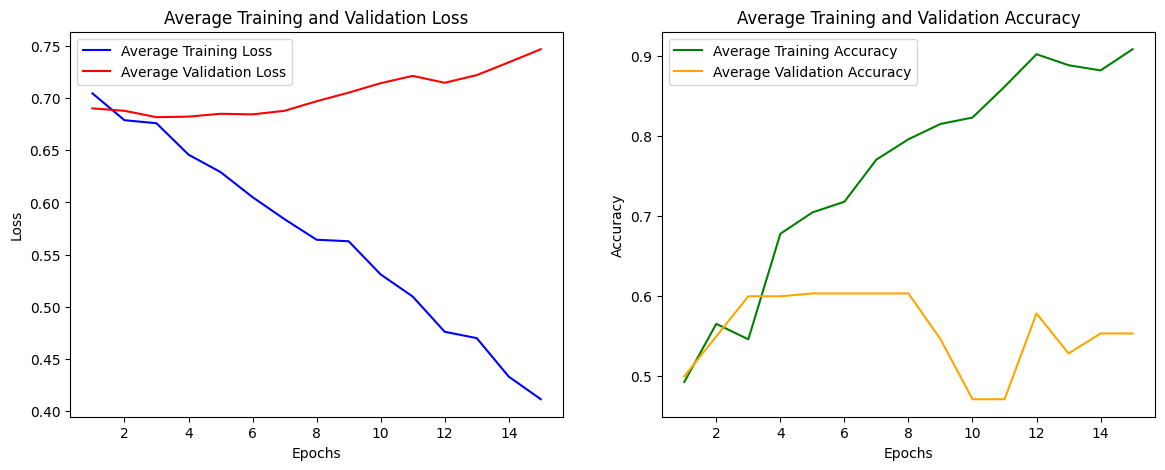

In [ ]:
trained_model = run_experiment()

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path),5)
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = trained_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

Test video path: /content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/lokzwdldxp.mp4
1/1 [==============================] - 8s 8s/step
  REAL: 64.85%
  FAKE: 35.15%


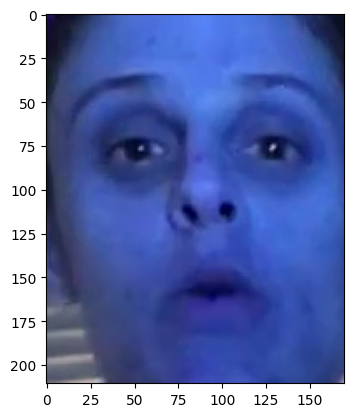

In [ ]:
test_video = '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/lokzwdldxp.mp4'
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)

In [ ]:
# Save the model to a file
trained_model.save("trained_model.h5")